In [ ]:
%pip install faiss-cpu

RAG에서 Retrieval 파트 구조

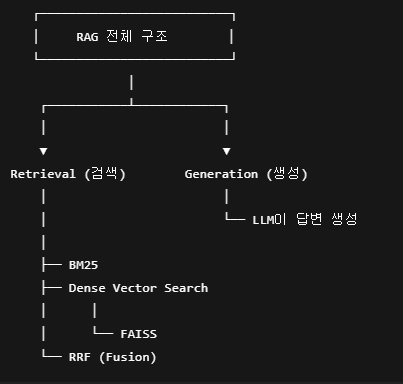

<span style="color: Gold"> 1. Dense Vector Search (밀집 벡터 검색) => 의미 검색 (AI가 의미 이해). 임베딩 기반


$$
\text{similarity}(q, d) = \cos(\theta)
= \frac{q \cdot d}{\|q\| \times \|d\|}
$$


<span style="font-size:12px;">

- 원리 
    - 문장을 고차원 벡터로 변환하고 <span style="color: yellow"> 코사인 유사도를 이용해서 의미적 유사성 측정</span>
    - 문장의 의미를 숫자 벡터로 변환해서 검색
    - AI 모델이 문장을 이해하고 벡터(숫자 배열)로 표현
- 장점: 의미적 유사성 포착(동의어)
    - 비가온다 <-> 장마가 시작됐다  --> 두 문장을 유사하게 받아들임
- 단점 : 고유명사, 숫자 등 정확한 매칭에 약함

<br>  

- <span style="color: pink">FAISS(Facebook AI Similarity Search)</span>  
    - 페북 메타에서 만든 고차원 벡터 검색 라이브러리. 가장 유사한 벡터를 빠르게 찾는 것이 목적
    - 유사 벡터 검색: L2 거리, cosine similarity 등으로 가장 가까운 벡터 찾기
    - 인덱스 구조 지원
        - Flat: 완전 탐색, 정확하지만 느림
        - IVF: 벡터를 클러스터로 나누어 탐색
        - HNSW: 그래프 기반 근사 최근접 탐색


      <span style="color: yellow"> 전체 과정 : 문장 → 임베딩 모델 → 768차원 벡터 → FAISS에 저장 → 유사한 벡터 검색

<span style="color: Gold"> 2. BM25 (Best Match 25) => 키워드 검색 (단어 일치 확인)

$$
\text{BM25}(D, Q) = \sum_{q_i \in Q} \text{IDF}(q_i) \cdot
\frac{f(q_i, D)(k_1 + 1)}
{f(q_i, D) + k_1\left(1 - b + b \cdot \frac{|D|}{\text{avgdl}}\right)}
$$

<span style="font-size:12px;">

- 용어
    - **IDF(qᵢ)**: 단어 qᵢ의 역문서 빈도 (드문 단어일수록 값이 큼)  
    - **f(qᵢ, D)**: 문서 D에서 단어 qᵢ가 등장한 횟수  
    - **k₁**: 포화 파라미터 (일반적으로 1.2 ~ 2.0)  
    - **b**: 문서 길이 정규화 파라미터 (일반적으로 0.75)  
    - **avgdl**: 전체 문서들의 평균 길이

<br>    

- 원리
    - 전통적인 키워드 기반 검색 알고리즘
    - TF-IDF 개선버전-> <span style="color: yellow">문서 내 단어 빈도와 희소성을 고려함</span>
- 장점: 정확한 키워드 매칭. 고유명사 검색에 강함
- 단점: 의미적 유사성 포착 불가
    - 비 <-> 장마의 연결이 어려움


<span style="color: Gold"> 3. Reciprocal Rank Fusion (RRF) => 검색 결과를 합쳐서 최종 점수 계산

$$
\text{RRF}(d) = \sum_i \frac{1}{k + \text{rank}_i(d)}
$$

<span style="font-size:12px;">

- 용어
    - **d**: 문서  
    - **k**: 상수 (일반적으로 60 사용)  
    - **rankᵢ(d)**: i번째 검색 시스템에서 문서 d가 받은 순위
- 원리
    - 여러검색 결과의 순위를 통합하여 최종 랭킹을 생성
- 장점: 다양한 검색 방식의 장점 결합.점수 스케일이 다른 검색 결과도 통합 가능



시각화

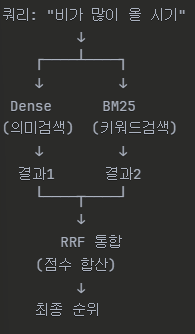


예시

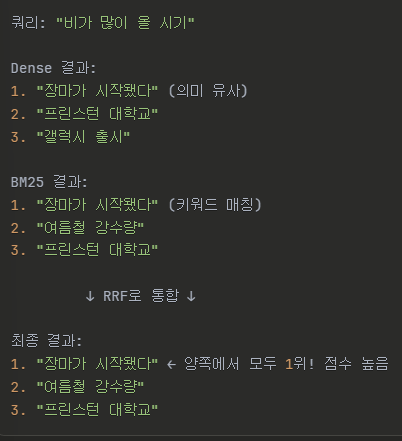

---

<span style="color: Gold"> 1. Dense Vector Search - FAISS 활용

<span style="color: lightblue;"> 전체흐름

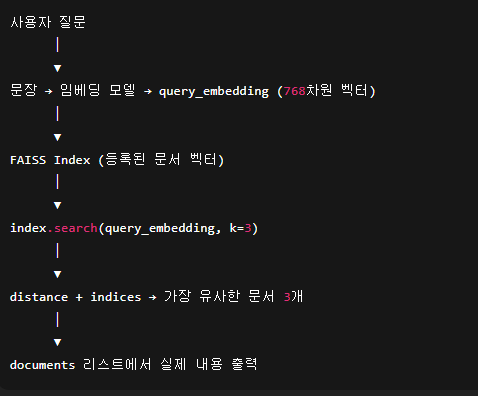

In [2]:
# 문장 임베딩으로 벡터 검색
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

In [ ]:
# 한국어 임베딩 모델 로드
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
#sample doc
documents = [
    "올해 여름 장마가 시작됐다",
    "프린스턴 대학교에서 학위를 받았다",
    "갤럭시 S5가 출시됐다"
]
# 문서 임베딩
doc_embeddings = model.encode(documents)  # 문서를 벡터로 변환(임베딩)

# FALSS 인덱스 생성 # FALSS : 페북에서 만든 고속 벡터 검색 라이브러리
dimension = doc_embeddings.shape[1]   # (3,768) # 문서 수는 3개, 문서마다 768차원 벡터가 있다
index = faiss.IndexFlatL2(dimension)  # 벡터를 효율적으로 검색하기 위해 저장하고 준비하는 공간. 벡터들의 리스트 + 검색 알고리즘을 담고 있는 구조체
                                      # IndexFlatL2: L2 거리(유클리드 거리)로 유사도 계산, 벡터 간 거리가 가까울수록 의미가 유사
index.add(doc_embeddings.astype('float32')) # 3개의 문서 벡터를 FAISS 인덱스 안에 등록. 등록 이후부터 FAISS는 이 벡터들을 기준으로 가장 가까운 벡터를 찾아주는 검색 기능 제공
# 쿼리 생성
query = '비가 많이 올 시기는?'
query_embedding = model.encode([query]) # 쿼리(질문) 벡터로 변환 (임베딩) -> (1,768) 형태의 벡터. 질문은 하나고 768 차원의 질문. 문서와 같은 차원이여야 질문과 문서 비교 가능
distance, indices = index.search(query_embedding.astype('float32'), k=3)  # 유사한 문서 검색 / distance(각 문서와의 거리) 작을수록 유리/ indices 문서 인덱스
print('검색결과')
for i ,(dist, idx) in enumerate(zip(distance[0],indices[0])):
  print(f'{i+1}, {documents[idx]} (거리: {dist:.4f})')


검색결과
1, 올해 여름 장마가 시작됐다 (거리: 391.9998)
2, 갤럭시 S5가 출시됐다 (거리: 702.7927)
3, 프린스턴 대학교에서 학위를 받았다 (거리: 717.1246)


<span style="color: lightblue;"> 비유하자면...  </SPAN>  

<span style="font-size:12px;">

FAISS 인덱스 = 도서관    
문서 벡터 = 책  
add() = 책을 도서관 서가에 꽂는 것  
이후 index.search() = 책을 찾기 위해 도서관 서가를 뒤지는 것  

---

<span style="color: Gold"> 2. BM25 검색 구현

<span style="color: lightblue;"> 전체 흐름

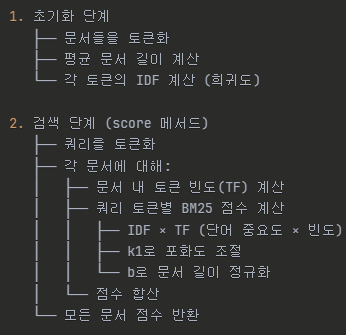

* 과정:  
<span style="color: yellow"> 문서를 토큰화 → IDF 계산 → 쿼리 입력 ->  BM25 점수를 계산 </SPAN>
<br>  
<span style="font-size:12px;">  
        * IDF 계산 : 각 단어가 전체 문서에서 얼마나 희귀한지를 계산. 자주 등장하는 단어는 가중치를 낮추고, 희귀 단어는 높임  
        * 단어 빈도(TF)

In [ ]:
import math
from collections import defaultdict
from transformers import AutoTokenizer
class SimpleBM25:
  # 클래스 초기화
  def __init__(self, documents, k1=1.2, b=0.75):
    self.tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base') # 한국어 문장을 토큰(단어)으로 분리
    self.k1 = k1  # 하이퍼파라미터 저장 / TF 포화도 조절 -> 높을수록 단어 빈도가 점수에 더 많이 영향
    self.b  = b   # 하이퍼파라미터 저장 / 문서 길이 정규화 -> 1에 가까울수록 긴 문서 불이익 크게 적용
    # 문서의 길이를 고려하는 이유는 문서가 길수록 해당 단어가 많이 포함되어있을 확률이 높기 때문에. 문장 정규화를 통해 점수 계산시 점수조절
    self.documents = documents  # 문서 저장
    self.tokenized_docs = [ self.tokenizer.tokenize(doc) for doc in documents ] # 문서마다 토큰화된 리스트 저장
    self.avg_doc_len = sum(len(d)  for d in self.tokenized_docs) / len(self.tokenized_docs) # 평균 문서 길이 계산 -> 문서 길이 보정에 사용
    self.idf = self._compute_idf()  # IDF 계산 -> _compute_idf()를 호출하여 모든 토큰의 IDF를 계산
  # IDF 계산 -> 각 단어가 얼마나 희귀한지 계산. 단어가 등장한 문서 수
  def _compute_idf(self):
    idf = defaultdict(float)      # defaultdict(float) → 기본값 0.0인 딕셔너리/ 모든 토큰별 IDF 값을 저장할 공간
    N = len(self.tokenized_docs)  # 전체 문서 수
    # TF 각 단어의 문서 빈도 계산 -> 문서 내 단어 중요도
    tf = defaultdict(int)
    for doc in self.tokenized_docs:
      for token in set(doc):  # set(doc) → 한 문서에서 중복 제거 -> 단어가 몇개의 문서에서 나타났는지 보는 것이기 때문에 중복을 제거한다
        tf[token] += 1       # tf[token] 단어가 등장한 문서의 수(문서 단위로 세기)
    # IDF 계산 
    for token,freq in tf.items():
      # 비율이 클수록(드문 토큰일수록) 값이 커지며, 흔한 토큰일 수록 작아진다
      idf[token] = math.log((N - freq + 0.5) / (freq + 0.5)+1 )  # 토큰이 나타나지 않은 문서수  , 토큰이 등장한 문서수
    return idf

  # 점수 계산
  def score(self, query):
    query_tokens =  self.tokenizer.tokenize(query)  # 쿼리 토큰화
    scores = []
    for doc in self.tokenized_docs:   # 각 문서에 대한 점수 계산
      score = 0
      doc_len = len(doc)  # doc_len → 문서 길이, BM25 문서 길이 보정에 사용
      # 단어 빈도 계산
      tf = defaultdict(int)
      for token in doc:
        tf[token] += 1
      for token in query_tokens:  # BM25 점수 계산
        if token in tf:
          freq = tf[token]
          numerator = self.idf[token] * freq + (self.k1 + 1)  # self.idf[token] -> IDF/  freq → TF
          denoinator = freq + self.k1 * (1 - self.b + self.b*doc_len / self.avg_doc_len)  # BM 공식
          # freq : 현재 문서에서 쿼리 단어가 등장한 횟수 -> 단어가 많이 나올수록 점수 높아지는 부분
          # k1 → TF 포화도 조절값 -> 단어 빈도가 지나치게 많아도 점수가 무한대로 올라가지 않도록 조절
          # (1 - b + b * doc_len / avg_doc_len) → 문서 길이 보정
          # b가 0이면 → 문서 길이 무시
          # b가 1이면 → 문서 길이에 비례해서 점수 조정
          score += numerator / denoinator
      scores.append(score)
    return scores


In [ ]:
# 사용
documents = ["로버트 헨리 딕이 1946년에 연구했다", "2023년 AI 기술이 발전했다", "프린스턴 대학교"]
bm25 = SimpleBM25(documents)
query = '로버트 핸리 딕 연구'
scores = bm25.score(query)
print(f'bm25 점수 : {scores}')

<span style="color: Gold"> 3. RRF
- 문서를 분석하거나, TF/IDF 계산하지 않음, 임베딩도 생성하지 않음
- 두 검색 엔진의 "순위 리스트"를 받아 합산

1) Dense 검색 (FAISS, 문장 벡터 기반)
2) Sparse 검색 (BM25, 단어 기반)
3) RRF(Reciprocal Rank Fusion)로 두 검색 결과 통합

Dense ranking ┐  
-----------------├──► RRF ─► 최종 순위  
Sparse ranking┘  

<span style="color: Gold"> 4. 하이브리드 검색 : 밀집벡터 + BM25 -> RANK
- 여러 검색 결과의 순위를 RRF로 통합

In [ ]:
def reciprocal_rank_fusion(rankings, k=60): # ranking은 1등부터 차례대로 문서의 아이디가 들어있다 1등 3번 2등 1번 3등 2번이라면 [3,1,2] 이렇게
  '''
  여러 검색결과의 순위를 RRf로 통합
  Args:
    rankings : 각 검색방식의 문서 인덱스 순위 리스트
    k: 상수
  Return:
    통합 점수로 정렬된(문서인덱스, 점수) 리스트
  '''
  rrf_scores = defaultdict(float)  # 문서별 RRF 점수를 저장할 딕셔너리/ 
  for ranking in rankings:         # 각 ranking(=Dense, Sparse)을 하나씩 읽는다
    for rank, doc_id in enumerate(ranking, 1):  # 순위 + 문서ID를 가져오면서 점수 계산
      rrf_scores[doc_id] += 1.0 / (k + rank)  # Score 공식 "1 / (k + rank)"" -> 순위가 높을수록(1등에 가까울수록) 점수가 커짐
  return sorted(rrf_scores.items(), key = lambda x : x[1], reverse=True)  # 순위가 높은 순으로 정렬

def hybrid_search(query,desnse_index, documents, bm25, top_k=3 ,rrf_k=60):

  # Dense Search FAISS -> Dense 검색 (FAISS + 임베딩)
  query_embedding = model.encode([query])
  D,I =  desnse_index.search(query_embedding.astype('float32'), k=top_k)
  desnse_ranking = list(I[0])
  print(f'desnse_ranking : {desnse_ranking}')

  # BM25 -> Sparse 검색
  sparse_scores =  bm25.score(query)
  sparse_ranking = list(np.argsort(sparse_scores)[::-1][:top_k] )

  # RRF 통합
  results = reciprocal_rank_fusion([desnse_ranking,sparse_ranking], k=rrf_k)
  return results

In [ ]:
documents = [
    "올해 여름 장마가 시작됐다",
    "프린스턴 대학교에서 학위를 받았다",
    "갤럭시 S5가 출시됐다"
]
# 한국어 SBERT 모델
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
doc_embeddings = model.encode(documents).astype('float32')
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

bms25 = SimpleBM25(documents)

# 하이브리드 검색
query = '비가 많이 올 시기는'
results = hybrid_search(query, index, documents,bm25,top_k=3)

print(f'하이브리드 검색 결과')
for rank, (doc_id, score) in enumerate(results, 1):
  try:
    print(f'{rank}. {documents[doc_id]} (점수 : {score:.4f})')
  except:
    pass